In [1]:
#https://simpletransformers.ai/docs/installation/
!pip install simpletransformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
cd /content/drive/My Drive/AI_assignment/

[Errno 2] No such file or directory: '/content/drive/My Drive/AI_assignment/'
/content


In [62]:
#https://huggingface.co/docs/datasets/v1.11.0/loading_datasets.html
## download the dataset 
from datasets import load_dataset

## Squad is Q & A dataset
datasets = load_dataset("squad")

## Check the number of record/dataformat in train and validation
print(datasets["train"])
print(datasets["validation"])

print(datasets["train"][0])
print(datasets["validation"][5])

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 87599
})
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 10570
})
{'id': '5733be284776f41900661182', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'question': 'To whom 

## Process and reformat the Train and test dataset to pass to SimpleTransformer

https://www.kaggle.com/code/ejaz22/question-answering-using-simpletransformer/notebook

sample 1   
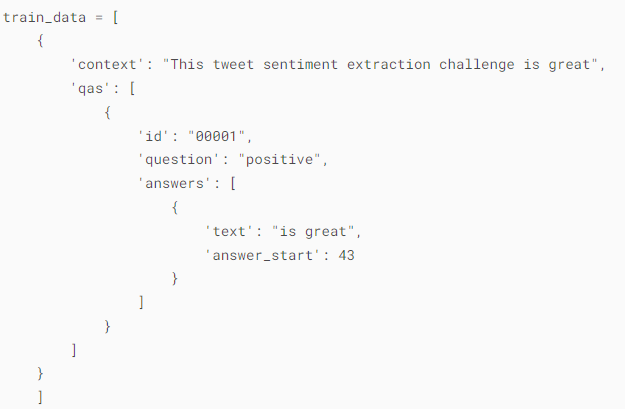

sample 2    
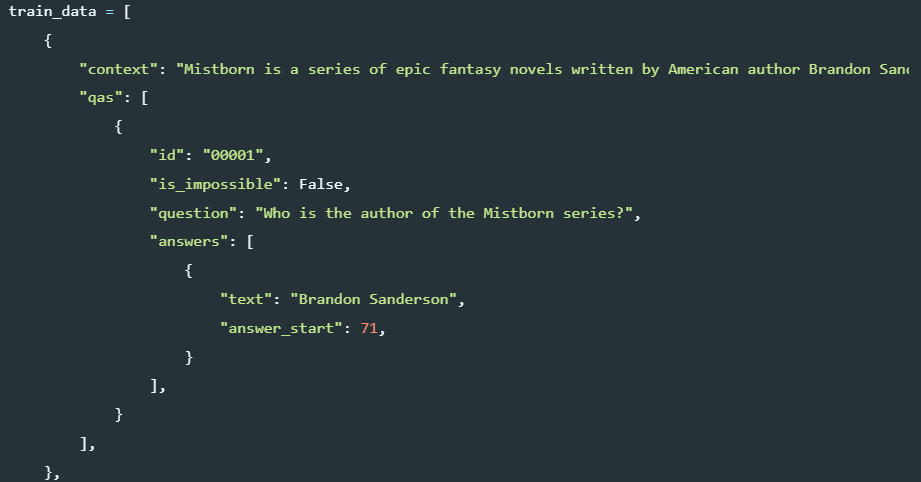

In [49]:
 ### Format source :: https://simpletransformers.ai/docs/qa-minimal-start/

def prepare_data_format(data):

  formatted_data = []

  for i in range(len(data)):
    current_row = data[i]
    formatted_dict = {}
    
    formatted_dict['context'] = current_row.get('context')
    
    ## Qas list contains dictionary of question and corresponding list of answers
    qas = []
    quest_dict = {}
    quest_dict['id'] = current_row.get('id')
    quest_dict['question'] = current_row.get('question')

    ## creating empty list of answers
    answers = []
    org_answer =  current_row.get('answers')

    ## is_impossible: (bool) Indicates whether the question can be answered correctly from the context 
    if (len(org_answer['text']) > 0):
      quest_dict['is_impossible'] = False

      for j in range(len(org_answer['text'])):
        answers_dict = {}
        answers_dict['text'] =  org_answer['text'][j]
        answers_dict['answer_start'] =  org_answer['answer_start'][j]
        answers.append(answers_dict)

    ## If no answer is there,then we make impossible True
    else:
      quest_dict['is_impossible'] = True
      answers_dict = {}
      answers.append(answers_dict)

    quest_dict['answers'] = answers 
    qas.append(quest_dict)

    formatted_dict['qas'] = qas
    formatted_data.append(formatted_dict)

    return formatted_data


train_data = prepare_data_format(datasets["train"])
test_data = prepare_data_format(datasets["validation"])

train_data[0]

{'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'qas': [{'id': '5733be284776f41900661182',
   'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
   'is_impossible': False,
   'answers': [{'text': 'Saint Bernadette Soubirous', 'answer_start': 515}]}]}

## Use pretrained models and Train over our formatted dataset

In [50]:
#https://simpletransformers.ai/docs/qa-minimal-start/
import logging

from simpletransformers.question_answering import QuestionAnsweringModel, QuestionAnsweringArgs

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

model_type="distilbert"
model_name= "distilbert-base-uncased-distilled-squad"
if model_type == "bert":
    model_name = "bert-base-cased"

elif model_type == "roberta":
    model_name = "roberta-base"

elif model_type == "distilbert":
    model_name = "distilbert-base-uncased-distilled-squad"

elif model_type == "distilroberta":
    model_type = "roberta"
    model_name = "distilroberta-base"

elif model_type == "electra-base":
    model_type = "electra"
    model_name = "google/electra-base-discriminator"

elif model_type == "electra-small":
    model_type = "electra"
    model_name = "google/electra-small-discriminator"

elif model_type == "xlnet":
    model_name = "xlnet-base-cased"

In [54]:
### https://www.kaggle.com/code/ejaz22/question-answering-using-simpletransformer/notebook
## https://simpletransformers.ai/docs/usage/
train_args = {'reprocess_input_data': True,
              'overwrite_output_dir': True,
              'learning_rate': 5e-5,
              'num_train_epochs': 20,

              ## For early stop
              'evaluate_during_training': True,
              "use_early_stopping": True,
              "early_stopping_metric": "eval_loss",
              #"early_stopping_patience": 3,
              'weight_decay' : 0.01,

              ## Specify the max context length
              'max_seq_length': 512,
              ## The authorized overlap between two part of the context when splitting
              'doc_stride': 128,
              'fp16': False
              }

# Create the QuestionAnsweringModel
model = QuestionAnsweringModel(model_type,model_name, 
                               args=train_args,
                              use_cuda=False)

model.train_model(train_data, eval_data=test_data)

# Evaluate the model
result, texts = model.eval_model(test_data)

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 7037.42it/s]


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Running Epoch 0 of 20:   0%|          | 0/1 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 1/1 [00:00<00:00, 125.70it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 282.60it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 20:   0%|          | 0/1 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 1/1 [00:00<00:00, 88.79it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 7570.95it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 2 of 20:   0%|          | 0/1 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 1/1 [00:00<00:00, 3563.55it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 7256.58it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 3 of 20:   0%|          | 0/1 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 1/1 [00:00<00:00, 118.03it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 7543.71it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 4 of 20:   0%|          | 0/1 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 1/1 [00:00<00:00, 70.14it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 853.19it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 5 of 20:   0%|          | 0/1 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 1/1 [00:00<00:00, 77.82it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 7281.78it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 6 of 20:   0%|          | 0/1 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 1/1 [00:00<00:00, 908.25it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 6754.11it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 7 of 20:   0%|          | 0/1 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 1/1 [00:00<00:00, 605.15it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 7231.56it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 8 of 20:   0%|          | 0/1 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 1/1 [00:00<00:00, 56.29it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 6594.82it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 9 of 20:   0%|          | 0/1 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 1/1 [00:00<00:00, 40.60it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 7752.87it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 10 of 20:   0%|          | 0/1 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 1/1 [00:00<00:00, 617.81it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 6775.94it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 11 of 20:   0%|          | 0/1 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 1/1 [00:00<00:00, 92.52it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 6260.16it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 12 of 20:   0%|          | 0/1 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 1/1 [00:00<00:00, 78.70it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 7219.11it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 13 of 20:   0%|          | 0/1 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 1/1 [00:00<00:00, 57.39it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 6710.89it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 14 of 20:   0%|          | 0/1 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 1/1 [00:00<00:00, 44.02it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 5511.57it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 15 of 20:   0%|          | 0/1 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 1/1 [00:00<00:00, 23.40it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 6087.52it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 16 of 20:   0%|          | 0/1 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 1/1 [00:00<00:00, 411.05it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 10155.70it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 17 of 20:   0%|          | 0/1 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 1/1 [00:00<00:00, 3284.50it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 7219.11it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 18 of 20:   0%|          | 0/1 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 1/1 [00:00<00:00, 64.13it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 6533.18it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 19 of 20:   0%|          | 0/1 [00:00<?, ?it/s]


convert squad examples to features: 100%|██████████| 1/1 [00:00<00:00, 89.33it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 6657.63it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 7667.83it/s]


Running Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

## Evaluate the model

In [55]:
to_predict  = [
    {
        'context': "This tweet sentiment extraction challenge is great",
        'qas': [
            {
                'id': "00001",
                'question': "how is the extraction challenge?"
            }
        ]
    }
    ]
answers, probabilities = model.predict(to_predict)
print(probabilities)
print(answers)

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 8019.70it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

[{'id': '00001', 'probability': [0.34754742836326374, 0.3100144069949746, 0.14406312528287432, 0.132783192256114, 0.01481438068934457, 0.01471984173462406, 0.007598605354893789, 0.006140761827207435, 0.006101574147580076, 0.005623829772623792, 0.0031497250328464607, 0.00290310614717772, 0.0014529979697266166, 0.0010976872487330244, 0.00045500626024011905, 0.00045298237934518503, 0.00041937993232180233, 0.0002359249553301483, 0.0002153008547629034, 0.0002107152913102473]}]
[{'id': '00001', 'answer': ['This tweet sentiment extraction challenge is great', 'great', 'tweet sentiment extraction challenge is great', 'sentiment extraction challenge is great', 'This tweet', 'This tweet sentiment', 'This tweet sentiment extraction challenge', 'tweet', 'tweet sentiment', 'sentiment', 'tweet sentiment extraction challenge', 'sentiment extraction challenge', 'is great', 'This tweet sentiment extraction', 'tweet sentiment extraction', 'extraction challenge is great', 'sentiment extraction', 't senti

In [56]:
# Make predictions with the model
to_predict = [
    {
        "context": """Keras is an API designed for human beings, not machines. Keras follows best
        practices for reducing cognitive load: it offers consistent & simple APIs, it minimizes
        the number of user actions required for common use cases, and it provides clear &
        actionable error messages. It also has extensive documentation and developer guides. """,
        "qas": [
            {
                "question": "what is keras?",
                "id": "0",
            }
        ],
    }
]

answers, probabilities = model.predict(to_predict)

print(answers[0])
#print(answers[0]['answer'][0])
print(probabilities[0])

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 7681.88it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

{'id': '0', 'answer': ['an API designed for human beings, not machines.', 'API designed for human beings, not machines.', 'an API designed for human beings,', 'human beings, not machines', 'an API', 'designed for human beings, not machines', 'API designed for human beings,', 'Keras is an API designed for human beings, not machines.', 'machines', 'an API designed', 'human beings', 'for human beings, not machines', 'API', 'human beings, not machines.', 'not machines', 'designed for human beings', 'an API designed for human beings, not machines. Keras follows best practices for reducing cognitive load:', 'an API designed for human', 'designed for human beings, not machines.', 'an']}
{'id': '0', 'probability': [0.8927220408190878, 0.0422145795855567, 0.03140962367875788, 0.01504518049017604, 0.00897939831287282, 0.0028775846196695694, 0.001485282089957961, 0.0014138794405371476, 0.0008588457815873564, 0.0006041742217638775, 0.0005293511706531121, 0.0004964000183774976, 0.000424613157709635

In [59]:
question_data = {
  'qas': 
  [{'question': 'What color is the tree?',
    'id': 0,
    'answers': [{'text': ' ', 'answer_start': 0}],
    'is_impossible': False}],
  'context': 'This is an old tree. It is green and tall. '
  }

prediction = model.predict([question_data])
print(prediction)
answers, probabilities = prediction
print(answers[0]['answer'][0])

add example index and unique id: 100%|██████████| 1/1 [00:00<00:00, 5275.85it/s]


Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

([{'id': 0, 'answer': ['green', 'green and tall', 'It is green', 'This is an old tree. It is green', 'green and tall.', 'It is green and tall.', 'This is an old tree. It is green and tall.', 'It', 'This is an old tree. It', 'This', 'an old tree. It is green', 'old tree. It is green', 'tree. It is green', 'This is an old tree.', 'is green', 'green and', 'tall', 'an old tree. It is green and tall.', 'old tree. It is green and tall.', 'is an old tree. It is green']}], [{'id': 0, 'probability': [0.8275237777332632, 0.07572001396951254, 0.05709650011820732, 0.016169305489268995, 0.014010147424288511, 0.005224439348925249, 0.0014795224868081158, 0.0014639020980955068, 0.00041456622002195086, 0.0003943045469773455, 0.00013762170395560492, 0.00010980423200344236, 8.714623282343398e-05, 4.436351869601765e-05, 3.207534757803795e-05, 3.118784709358204e-05, 2.9345095557319762e-05, 1.2592650056015e-05, 1.0047297980955705e-05, 9.331120638836797e-06]}])
green
